In [1]:
import cv2
import re
import time
import numpy as np
import dask as d
import matplotlib.pyplot as plt

from glob import glob

In [6]:
from fl_tissue_model_tools import dev_config, defs, data_prep
from fl_tissue_model_tools import preprocessing as prep
from fl_tissue_model_tools import zstacks as zs

In [3]:
dirs = dev_config.get_dev_directories("../dev_paths.txt")

In [4]:
z_stack_data_dir = f"{dirs.data_dir}/z_projection"
z_proj_output_dir = f"{dirs.figures_dir}/2022_04_07_z_projection"

In [7]:
data_prep.make_dir(z_proj_output_dir)

In [8]:
z_ids = ["A1", "A2"]

In [18]:
def get_zstack(z_id, ext, descending):
    z_paths, z_stack = zs.z_stack_from_dir(f"{z_stack_data_dir}/{z_id}", ext, descending)
    z_stack = prep.min_max_(z_stack, defs.GS_MIN, defs.GS_MAX, defs.TIF_MIN, defs.TIF_MAX)
    return z_paths, z_stack


def compute_all_projections(z_stack, z_id):
    fs_proj = zs.proj_focus_stack(z_stack, axis=0, kernel_size=5)
    avg_proj = zs.proj_avg(z_stack, axis=0)
    med_proj = zs.proj_med(z_stack, axis=0)
    min_proj = zs.proj_min(z_stack, axis=0)
    max_proj = zs.proj_max(z_stack, axis=0)
    return {"fs": fs_proj, "avg": avg_proj, "med": med_proj, "min": min_proj, "max": max_proj}

In [19]:
# {z_1: (z_paths, z_stack), z_2: (z_paths, z_stack), ...}
z_stacks = d.compute(
    d.delayed({z_id: get_zstack(z_id, "tif", True) for z_id in z_ids})
)[0]

In [20]:
z_projections = d.compute(
    d.delayed({z_id: compute_all_projections(z_stacks[z_id][1], z_id) for z_id in z_ids})
)[0]

# Visualize

In [31]:
def show_well(proj, cmap="gray", vmin=defs.GS_MIN, vmax=defs.GS_MAX, h=8, w=8):
    plt.figure(figsize=(h, w))
    plt.imshow(proj, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.show()

In [32]:
target_id = "A1"

## Focus stacking

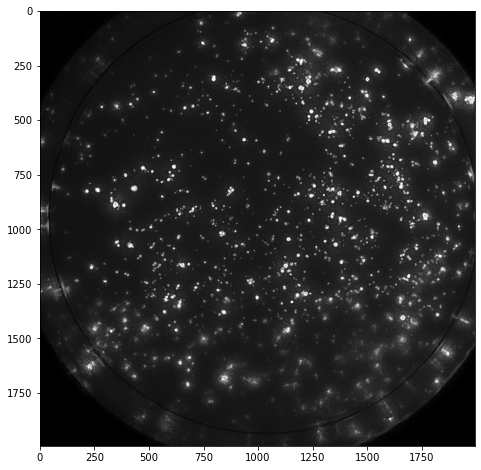

In [34]:
show_well(z_projections[target_id]["fs"])

## Average

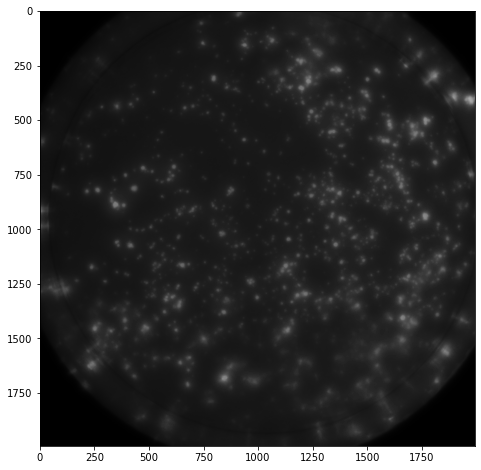

In [35]:
show_well(z_projections[target_id]["avg"])

## Median

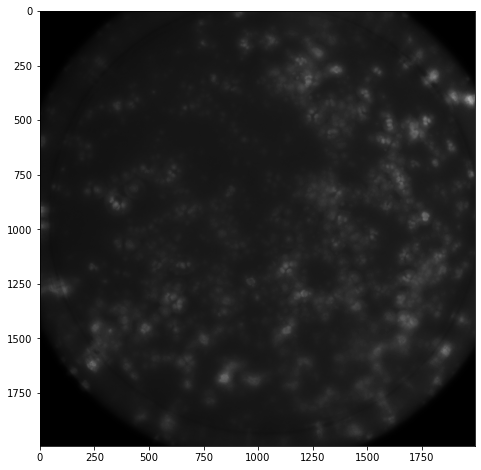

In [36]:
show_well(z_projections[target_id]["med"])

## Min

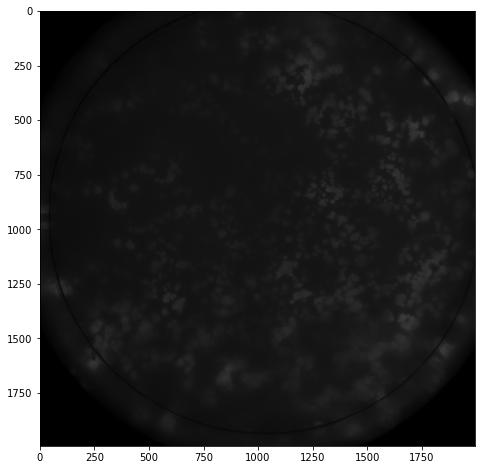

In [38]:
show_well(z_projections[target_id]["min"])

## Max

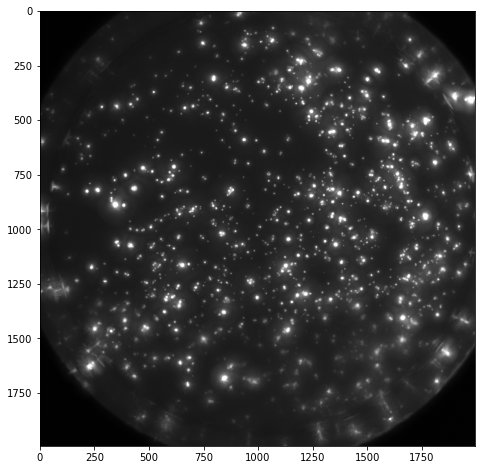

In [39]:
show_well(z_projections[target_id]["max"])

# Save results

In [21]:
for zid, zps in z_projections.items():
    for zp_type, zp in zps.items():
        cv2.imwrite(
            f"{z_proj_output_dir}/{zid}_{zp_type}.tif",
            prep.min_max_(zp, defs.TIF_MIN, defs.TIF_MAX, defs.GS_MIN, defs.GS_MAX).astype(np.uint16)
        )